# Домашнее задание 1. Сбор данных

При решении реальных задач мы почти никогда не имеем дело с "хорошими" исходными данными, уже подготовленными для обработки и анализа. Как правило на входе имеются неструкткрированные данные в "грязном" виде, например необработанные тексты, изображения или аудио файлы. Иногда нет даже этого, и данные приходится собирать из разных доступных источников: разнообразных баз данных, внешних сервисов и даже электронных таблиц. После того, как данные получены, их унифицируют, очищают от шума, преобразовывают в нужный вид и сохраняют для дальнейшего анализа. В одном из традиционных подходов к [Data Mining](http://www.wikiwand.com/en/Online_analytical_processing) этот процесс называется Extract-Transform-Load ([ETL](http://www.wikiwand.com/en/Extract,_transform,_load)).

Цель этого задания собрать первые данные о пользователях из обучающей выборки и провести простейший качественный анализ. В ходе решения будут использованы:
1. [numpy](http://www.numpy.org/) -- библиотека для работы с многомерными массивами
2. [pandas](http://pandas.pydata.org/) -- библиотека, позволяющая удобно работать с различными типами данных
3. [requests](http://docs.python-requests.org/en/latest/) -- библиотека, которую можно использовать для вызова HTTP запросов
4. [python-twitter](https://github.com/bear/python-twitter/tree/master/twitter) -- обертка для Twitter API
5. [matplotlib](http://matplotlib.org/) -- библиотека для рисования графиков в python

Первым делом импортируем необходимые библиотеки и убеждаемся, что все установлено.

In [83]:
import pandas as pd
import numpy as np
import pylab as pl
import mpl_toolkits.basemap as bm
import twitter
import requests
import datetime
import dateutil
import csv
import os
import json

# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Чтение исходных данных из файла

Считываем исходные данные из файла в data frame библиотеки pandas. Полученный data frame должен иметь целочисленный ключ и две колонки:
1. uid -- идентификатор пользователя
2. cat -- числовой номер класса

In [84]:
TRAINING_SET_PATH = "train.csv"
TESTING_SET_PATH = "test.csv"
df_users_train = pd.read_csv(TRAINING_SET_PATH, sep=",", header=0)
df_users_ex = pd.read_csv(TESTING_SET_PATH, sep=",", header=0)
df_users_ex['cls'] = None
df_users = pd.concat([df_users_train, df_users_ex])
df_users.head()

,uid,cls
0,202388889,1.0
1,1392518336,0.0
2,361208576,1.0
3,1535215357,1.0
4,4396196375,1.0


Построим распределение целевой переменной. Требуется получить [barchart](http://www.wikiwand.com/en/Bar_chart), в котором высота столбика, соответствующего каждому из классов, пропорциональна количеству пользователей этого класса. По горизонтальной оси отложены классы (positive, negative), а по вертикальной -- количество пользователей.

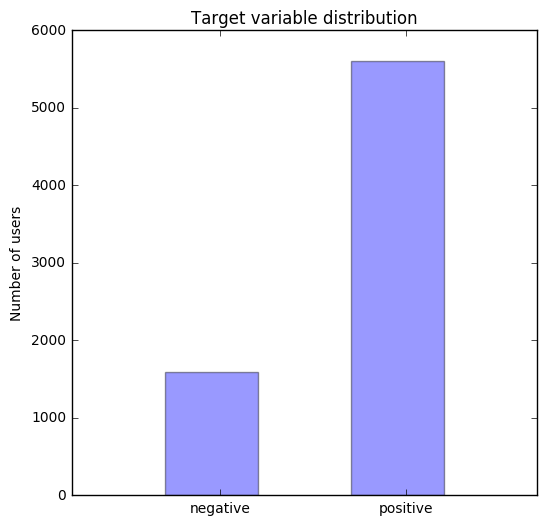

In [85]:
# Compute the distribution of the target variable
counts, bins = np.histogram(df_users_train["cls"], bins=[0,1,2])

# Plot the distribution
pl.figure(figsize=(6,6))
pl.bar(bins[:-1], counts, width=0.5, alpha=0.4)
pl.xticks(bins[:-1] + 0.3, ["negative", "positive"])
pl.xlim(bins[0] - 0.5, bins[-1])
pl.ylabel("Number of users")
pl.title("Target variable distribution")
pl.show()

## Сбор данных

Для того чтобы разработать модель, которая предсказывает значение целевой переменной для произвольного пользователя, недостаточно знать только значения идентификаторов пользоватей. Причина в том, что _user_id_ для пользователя никак не зависит от целевой переменной -- идентификатор генерируется на основании времени регистрации, сервера, обрабатывающего запрос, и номера пользователя ([подробности](https://dev.twitter.com/overview/api/twitter-ids-json-and-snowflake)).

Поэтому нам потребуется загрузить дополнительную информацию о каждом пользователе, иначе говоря провести сбор данных (data collection). Наиболее важную информацию можно загрузить из [Twitter](https://dev.twitter.com/rest/public) [API](http://www.wikiwand.com/en/Representational_state_transfer). При желании можно воспользоваться и другими источниками -- об этом ниже.

Для того, чтобы получить доступ к API прежде всего необходимо зарегистрироваться в Twitter в качестве разработчика и создать свое [приложение](https://apps.twitter.com/). После создания приложения будет доступен набор ключей, которые мы будем использовать для аутентификации. Эти ключи необходимо скопировать в соответствующие константы ниже. Подробнее о том, как работает аутентификация в Twitter API можно почитать [по ссылке](https://dev.twitter.com/oauth/application-only), хотя это нужно скорее для ознакомления: библиотека обращения с API позаботится о механизме аутентификации за нас.

In [99]:
CONSUMER_KEY = "idabqUjE9SgRA393e2ev61YGy"
CONSUMER_SECRET = "2zdArEX0hc9VMRAwNxgNCOlKyP0oPz7J5RCsPqesP2xwMnaOrT"

ACCESS_TOKEN_KEY = "780333099892797440-f5T7OEYUG211Q3r9HMqE6BxaK3xJ3UX"
ACCESS_TOKEN_SECRET = "D3dnEL2i2B1XovQlSW1J6V1PeNYJh9gbMTWYti0NQmolR"

api = twitter.Api(consumer_key=CONSUMER_KEY, 
                  consumer_secret=CONSUMER_SECRET, 
                  access_token_key=ACCESS_TOKEN_KEY, 
                  access_token_secret=ACCESS_TOKEN_SECRET)







Twitter API предоставляет информацию о местонахождении пользователя, но эта информация представлена в текстовом виде, например так:
```
"location": "San Francisco, CA"
```
Такие текстовый описания не слишком удобны для анализа, поэтому наша цель -- получить более структурированную информацию, такую как географические координаты, страна, город и т.д. Для этого удобно использовать геоинформационный сервис, например [GeoNames](http://www.geonames.org/export/web-services.html). Для его использования также необходимо зарегистрироваться, подтвердить регистрацию и включить поддержку API. После этого можно будет посылать запросы для нахождения нужной информации. Например на запрос
```
http://api.geonames.org/search?q="San Francisco, CA"&maxRows=10&username=demo
```
возвращается результат,
```javascript
{
    "totalResultsCount": 2112,
    "geonames": [
        {
            "countryId": "6252001",
            "adminCode1": "CA",
            "COUNTRY": "United States",
            "fclName": "city, village,...",
            "countryCode": "US",
            "lon": "-122.41942",
            "fcodeName": "seat of a second-order administrative division",
            "toponymName": "San Francisco",
            "fcl": "P",
            "name": "San Francisco",
            "fcode": "PPLA2",
            "geonameId": 5391959,
            "lat": "37.77493",
            "adminName1": "California",
            "population": 805235
        },
        {
            "countryId": "6252001",
            "adminCode1": "CA",
            "COUNTRY": "United States",
            "fclName": "spot, building, farm",
            "countryCode": "US",
            "lon": "-122.3758",
            "fcodeName": "airport",
            "toponymName": "San Francisco International Airport",
            "fcl": "S",
            "name": "San Francisco International Airport",
            "fcode": "AIRP",
            "geonameId": 5391989,
            "lat": "37.61882",
            "adminName1": "California",
            "population": 0
        }
    ]
}
```
из которого легко извлечь нужную информацию.

**Замечание: для запросов необходимо использовать своего пользователя, кроме того количество запросов ограничено 30тыс в день**.

Первым делом нам понадобится функция, которая возвращает информацию о местоположении для данного текстового запроса. Требуется реализовать функцию get_coordinates_by_location, принимающую на вход строку с местоположением и возвращает кортеж вида (долгота, широта, город).

In [100]:
GEO_USER_NAME = "azaza"
Finded_Coord = {} #словарь с найденными координатами

def get_coordinates_by_location(location):    
    """
    This function gets geographic coordinates and city name
    form external web service GeoNames using 'location' string.
    
    NOTE: the returned value is FAKE. It's only used to show
    NOTE: correct output format.
    """
    global Finded_Coord
    lat  = None # latitude  --- широта
    lon  = None # longitude --- долгота 
    
    if location != None:
        COUNTRY = unicode(location) 
    else: return None,None,None
    
    URL  = "http://api.geonames.org/searchJSON" 
    
    if location in Finded_Coord:
        return Finded_Coord[location]["lat"], Finded_Coord[location]["lon"], Finded_Coord[location]["COUNTRY"]
    
    params = dict(
        q = location,
        maxRows = "1",
        username = GEO_USER_NAME
    )
    
    #запрос о местоположении, перевод в json
    req = requests.get(URL=URL, params=params)
    data = json.loads(req.text)
    
    if 'geonames' in data and len(data['geonames']):
        lat = float(data['geonames'][0]['lat']) 
        lon = float(data['geonames'][0]['lon']) 
        if 'COUNTRY' in data['geonames'][0]:
            COUNTRY = data['geonames'][0]['COUNTRY']
        else:
            COUNTRY = data['geonames'][0]['name']
    Finded_Coord[location] = {"lat":lat, "lon":lon, "COUNTRY":COUNTRY}
    return lat, lon, COUNTRY

Следующий шаг -- вызов Twitter API для сбора данных и сохранения их в data frame. После чего data frame c собранными данными совмещается с data frame, содержащим данные исходной обучающей выборки. 

В этой части задания нужно реализовать функцию `get_user_records`, которая принимает на вход прочитанный из файла `data frame` и возвращает список словарей, каждый из которых представляет данные одного пользователя. Для того, чтобы получить из объекта класса [`User`](https://github.com/bear/python-twitter/blob/master/twitter/user.py) словарь в правильном формате, нужно использовать функцию `twitter_user_to_dataframe_record` (4 балла).

Так как скрипт работает существенное время, будем сохранять промежуточный результат.

In [101]:
ts_parser = lambda date_str: dateutil.parser.parse(date_str) if pd.notnull(date_str) else None

user_records = []
tmp_file_name = 'tmp_user_records'
if os.path.exists(tmp_file_name):
    with open(tmp_file_name) as f:
        for line in f:
            try:
                user_records.append(json.loads(line))
            except:
                continue

processed_users = set()
for r in user_records:
    processed_users.add(r['uid'])
    
f = open(tmp_file_name, 'a')
            
def twitter_user_to_dataframe_record(user):
    dt = ts_parser(user.created_at)
    record = {
        "uid": user.id,
        "name": user.name,
        "screen_name": user.screen_name,        
        "created_at": dt.strftime("%Y-%m") if dt else dt,        
        "followers_count": user.followers_count,
        "friends_count": user.friends_count,
        "statuses_count": user.statuses_count,
        "favourites_count": user.favourites_count,
        "listed_count": user.listed_count,
        "verified": user.verified
    }
    
    if user.description is not None and user.description.strip() != "":
        record["description"] = user.description
        
    if user.location is not None and user.location.strip() != "":
        record["location"] = user.location
        record["lat"], record["lon"], record["country"] = get_coordinates_by_location(user.location)
    
    return record


def get_user_records(df):
    global user_records
    all_users = df["uid"].values.tolist()
    id_list = [record["uid"] for record in user_records]
    for uid in id_list: all_users.remove(uid)
        
    for n in range(0, len(all_users), 100):
        user_ids = all_users[n:n+100]
        check = False
        while not check:
            try:
                user_list = api.UsersLookup(user_id=user_ids)
                #преобразуем результаты из twitter 
                for user in user_list:
                    new_user = twitter_user_to_dataframe_record(user)
                    f.write(json.dumps(new_user)+'\n')
                    user_records.append(new_user)
                check = True
                print "Downloaded %d of %d"%(len(user_records),len(all_users))
           
            except twitter.TwitterError, e:
                print e.args[0][0]["code"]
                check = True
                
                
            
    return user_records

# Maximum number of user IDs returned by Twitter's user lookup

user_records = get_user_records(df_users)
f.close()
        
print "Creating data frame from loaded data"
df_records = pd.DataFrame(user_records, columns=["uid", "name", "screen_name", "description", "verified", "location", "lat", "lon", "country", "created_at", "followers_count", "friends_count", "statuses_count", "favourites_count", "listed_count"])
print "Merging data frame with the training set"
df_full = pd.merge(df_users, df_records, on="uid", how="left")
print "Finished building data frame"

17
17
17
17
17
17
Creating data frame from loaded data
Merging data frame with the training set
Finished building data frame


In [92]:
e.args[0][0]["code"]

AttributeError: 'float' object has no attribute 'args'

## Exploratory Data Analysis

Для того, чтобы лучше понять, как устроена наша обучающая выборка, построим несколько графиков. Сначала построим долю "положительных" пользователей в зависимости от дня создания аккаунта. По горизонтальной оси отложим день создания аккаунта, а по вертикальной -- долю "положительных" пользователей ([подсказка](http://stroykova.github.io/sphera/l1_1.png)). Необходимо дописать код функции count_users. В функции необходимо посчитать пользователей в каждой группе (1 балл).

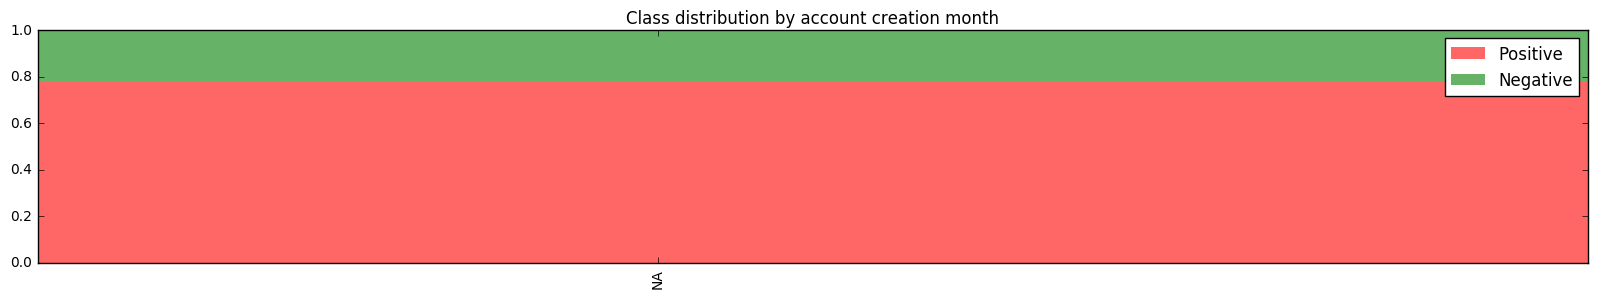

In [79]:


def count_users(grouped):
    """
    Counts number of positive and negative users
    created at each date.
    
    Returns:
        count_pos -- 1D numpy array with the counts of positive users created at each date
        count_neg -- 1D numpy array with the counts of negative users created at each date
        dts -- a list of date strings, e.g. ['2014-10', '2014-11', ...]
    """
    dts = []
    count_pos, count_neg = np.zeros(len(grouped)), np.zeros(len(grouped))
    # your code here 
    index = 0
    for user_group in grouped:
        dts.append(user_group[0])
        for a in user_group[1]["cls"].values:
            if a == 1.0: count_pos[index] += 1
            if a == 0.0: count_neg[index] += 1
        index += 1
    return count_pos, count_neg, dts


grouped = df_full.groupby(map(lambda dt: dt if pd.notnull(dt) else "NA", df_full["created_at"]))
count_pos, count_neg, dts = count_users(grouped)
    
fraction_pos = count_pos / (count_pos + count_neg + 1e-10)
fraction_neg = 1 - fraction_pos

sort_ind = np.argsort(dts)
    
pl.figure(figsize=(20, 3))
pl.bar(np.arange(len(dts)), fraction_pos[sort_ind], width=1.0, color='red', alpha=0.6, linewidth=0, label="Positive")
pl.bar(np.arange(len(dts)), fraction_neg[sort_ind], bottom=fraction_pos[sort_ind], width=1.0, color='green', alpha=0.6, linewidth=0, label="Negative")
pl.xticks(np.arange(len(dts)) + 0.4, sorted(dts), rotation=90)
pl.title("Class distribution by account creation month")
pl.xlim(0, len(dts))
pl.legend()
pl.show()



Видно, что доля "положительных" аккаунтов в выборке растет с увеличением времени. Посмотрим, где живут пользователи положительной и отрицательной категории. Для этого отметим на карте каждого положительного пользователя красным, а отрицательного -- зеленым цветом ([подсказка](http://stroykova.github.io/sphera/l1_2.png)). Необходимо реализовать функцию plot_points_on_map. В функции необходимо отобразить на карте пользователей из разных классов (2 балла).

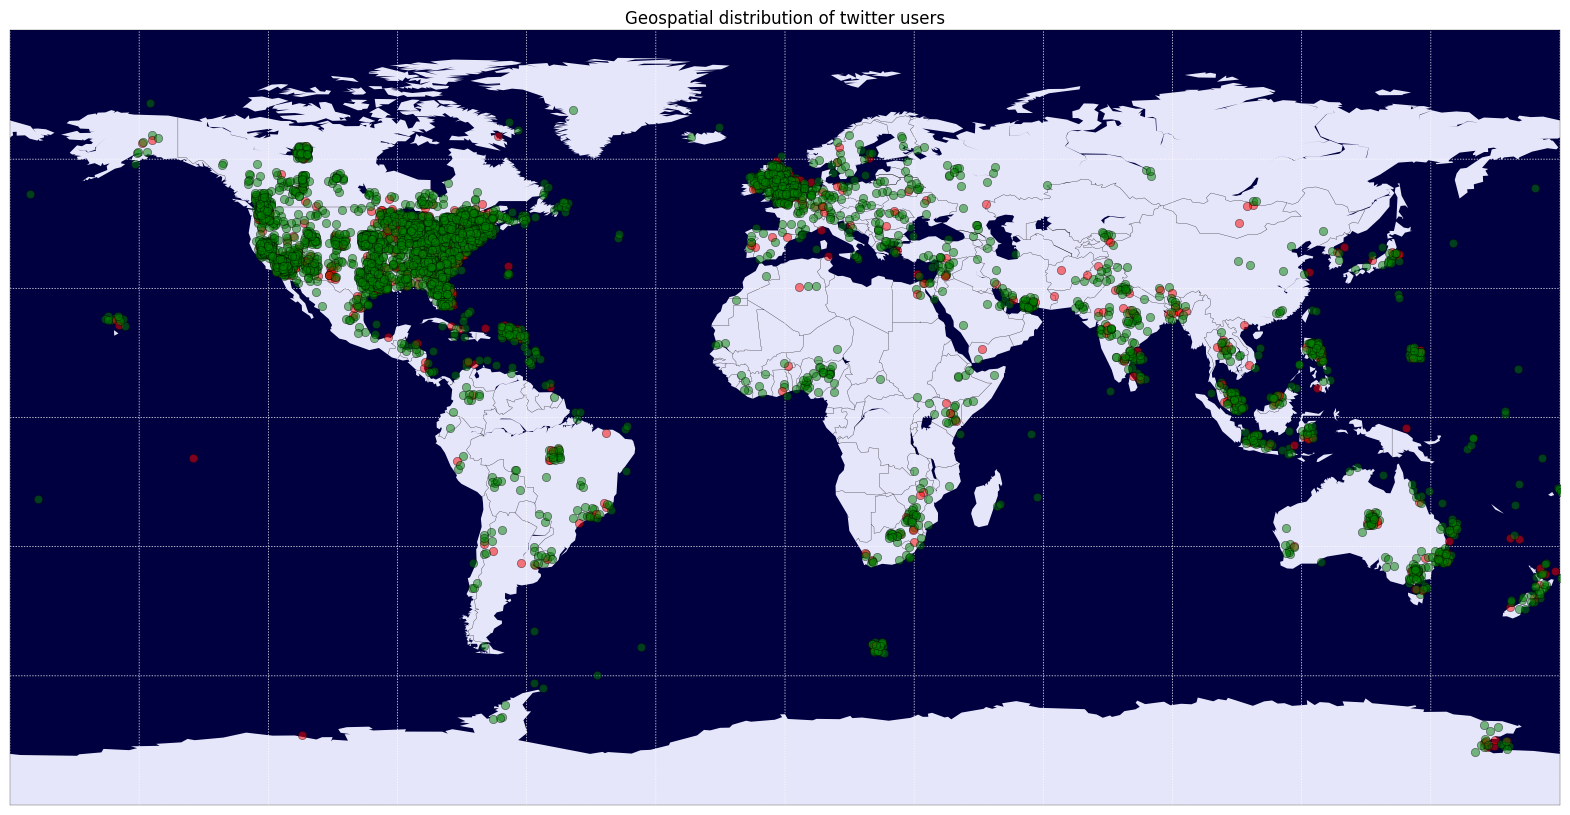

In [67]:
pl.figure(figsize=(20,12))

m = bm.Basemap(projection='cyl', llcrnrlat=-90, urcrnrlat=90, llcrnrlon=-180, urcrnrlon=180, resolution='c')

m.drawcountries(linewidth=0.2)
m.fillcontinents(color='lavender', lake_color='#000040')
m.drawmapboundary(linewidth=0.2, fill_color='#000040')
m.drawparallels(np.arange(-90,90,30),labels=[0,0,0,0], color='white', linewidth=0.5)
m.drawmeridians(np.arange(0,360,30),labels=[0,0,0,0], color='white', linewidth=0.5)

def plot_points_on_map(df_full):
    color = 0
    x = 0
    y = 0
    for index, row in df_full.iterrows():
        
        if row["lat"] and row["lon"]:
            y = random.random()*3 + row["lat"]
            x = random.random()*3 + row["lon"]
        if not row["lat"] and not row["lon"]:
            y = random.random()*3 - 55
            x = random.random()*3 + 20
        
        if row["cls"]:
            pl.plot(x, y, 'go', alpha = 0.5)
        else:
            pl.plot(x, y, 'ro', alpha = 0.5)
    
    return

plot_points_on_map(df_full)

pl.title("Geospatial distribution of twitter users")
pl.legend()
pl.show()

В последней картинке есть проблема: сервис геоинформации определяет координаты с точностью до города, поэтому точки, соответствующте нескольким пользователям, могут накладываться. Предложите и реализуйте способ, позволяющий справиться с этой проблемой (2 балла).


В поле ниже необходимо словами описать, как было улучшено изображение (описание необходимо для корректной проверки задания).

На изображении сделаны следующие улучшения:
* Координаты сдигаются на рандом
* Добавлена прозрачность
* Все пользователи без адекватного местоположения выброшены в океан по координатам -55, 20

#### Опредилим пользователи какого класса популярнее, а именно пользователи какого класса имеют больше фолловеров. 

Для этого
    1. Посчитайте дескриптивные статистики для признака followers_count -- min, max, mean и median 
    2. Постройте гистограммы для пользователей двух классов.
[подсказка](http://stroykova.github.io/sphera/l1_3.png) 
    3. На основе полученных данных ответьте на вопросы 
        1. Почему mean и median имеют разные значения
            Медиана - значение, делящее выборку на две равные половины. Среднее - среднее арифметическое. 
            Т.к.существуют выбросы, они оказывают сильное влияние на среднее(mean), а медиана более устойчива к влиянию выбросов, т.к. их немного(иначе бы они не назывались выбросами, ваш КЭП).
        2. Пользователи какого класса популярнее? Аргументируйте ответ.
            Для ответа сделаем несколько статистических выборок и посмотрим на различия медиан и средних.
            P.S. Как показывает код ниже, негативный класс популярнее.
Подсказка: так как пользователей позитивного класса в 3.5 раза больше, чем негативного прежде чем приступать к анализу необходимо случайным образом выбрать по N(N>=500) пользователей негативного и позитивного классов. (1 балл)

In [68]:
def stat_med_mean(df_full, a):
    number = 500
    pos_mean = 0.0
    pos_median = 0.0
    neg_mean = 0.0
    neg_median = 0.0
    for i in xrange(a):
        negative = df_full[df_full["cls"]==0].sample(sample_number)
        positive = df_full[df_full["cls"]==1].sample(sample_number)
        pos_mean += positive['followers_count'].mean()
        pos_median += positive['followers_count'].median()
        neg_mean += negative['followers_count'].mean()
        neg_median += negative['followers_count'].median()
    return pos_median/a, neg_median/a, pos_mean/a, neg_mean/a

print stat_med_mean(df_full, 500)
print stat_med_mean(df_full, 2000)
print stat_med_mean(df_full, 3000)
print stat_med_mean(df_full, 5000)

(366.487, 381.596, 2757.4547370373625, 3005.1072470947861)
(367.53625, 379.78625, 2791.5016055049928, 3041.1017328400749)
(366.54266666666666, 381.7108333333333, 2739.708425176997, 3044.8352278470998)
(367.7636, 381.5696, 2777.4819708244631, 3054.4727304474432)


NEGATIVE class:
 min = 0; 
 max = 124720; 
 median = 368; 
 mean = 2482;
POSITIVE class:
 min = 0; 
 max = 1319440; 
 median = 385; 
 mean = 4792.


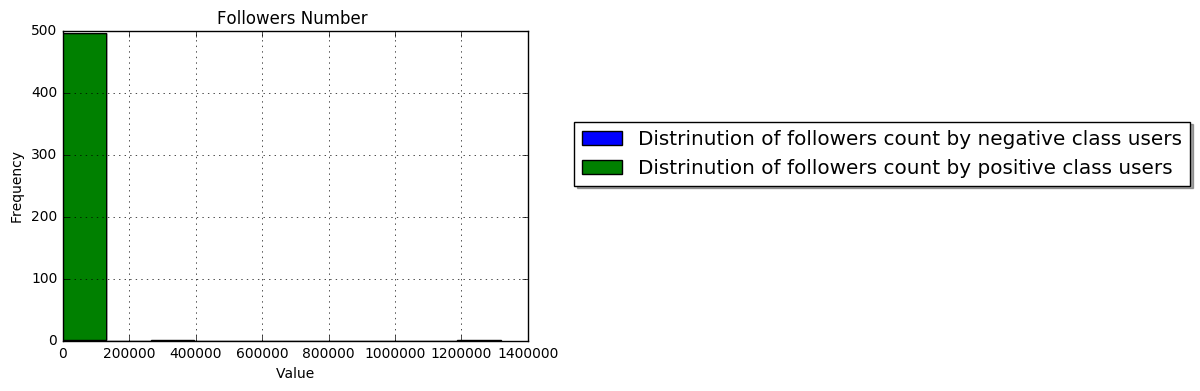

In [69]:
sample_number = 500
negative_class = df_full[df_full["cls"]==0].sample(sample_number)
positive_class = df_full[df_full["cls"]==1].sample(sample_number)

def descriptive_stat_and_hist(users_wth_neg_class, users_wth_pos_class):
        #Calculate min max and median. Plot histogram
        #Your code here
    print "NEGATIVE class:\n min = %d; \n max = %d; \n median = %d; \n mean = %d;"%(
            negative_class['followers_count'].min(),
            negative_class['followers_count'].max(),
            negative_class['followers_count'].median(),
            negative_class['followers_count'].mean())
    print "POSITIVE class:\n min = %d; \n max = %d; \n median = %d; \n mean = %d."%(
            positive_class['followers_count'].min(),
            positive_class['followers_count'].max(),
            positive_class['followers_count'].median(),
            positive_class['followers_count'].mean())
    
    negative_class['followers_count'].hist(label = "Distrinution of followers count by negative class users")
    positive_class['followers_count'].hist(label = "Distrinution of followers count by positive class users")
    pl.xlabel('Value')
    pl.ylabel('Frequency')
    pl.title('Followers Number ')
    pl.legend(loc = (1.1,0.5), shadow=True, fontsize='x-large')
    return
descriptive_stat_and_hist(negative_class, positive_class)


Смотрим на полученный data frame и сохраняем его в .csv файл.

In [66]:
OUT_FILE_PATH = "hw1_out.csv"
print "Saving output data frame to %s" % OUT_FILE_PATH
df_full.to_csv(OUT_FILE_PATH, sep="\t", index=False, encoding="utf-8", quoting=csv.QUOTE_NONNUMERIC)
df_full.head()

Saving output data frame to hw1_out.csv


,uid,cls,name,screen_name,description,verified,location,lat,lon,country,created_at,followers_count,friends_count,statuses_count,favourites_count,listed_count
0,202388889,1.0,Kim Salter,mustangkim11,Author- Artist-Marvel-Cars-Books-Music,False,"Gulfport, FL",27.74836,-82.70343,United States,2010-10,1059.0,1982.0,9511.0,21604.0,26.0
1,1392518336,0.0,Tomboy Tarts,TomboyTarts,Celebrating the classic tomboy spirit with a b...,False,Singapore/Malaysia,1.54860,103.52690,Malaysia,2013-04,1226.0,848.0,19558.0,7265.0,118.0
2,361208576,1.0,THE MANC GEEK,BigA85GL,"Mancunian geek, blogger/writer/reviewer. Consu...",False,"Manchester, UK",53.48095,-2.23743,United Kingdom,2011-08,631.0,578.0,7915.0,1139.0,31.0
3,1535215357,1.0,Lauryn 🎃,laurynjiles,"xoxo, gossip girl.",False,#BLM,NaN,NaN,#BLM,2013-06,2365.0,2055.0,188108.0,90281.0,69.0
4,4396196375,1.0,#1stEdifyToUplift,EdifyToUplift,Formerly @ ChadwickNChill | Awareness.Advocacy...,False,God is my refuge,NaN,NaN,God is my refuge,2015-12,1245.0,999.0,40037.0,29140.0,80.0
